<a href="https://colab.research.google.com/github/Christiankeviny/chatbot_LSTM/blob/main/chatbot_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://huggingface.co/datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset

Cloning into 'Bitext-customer-support-llm-chatbot-training-dataset'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 32 (delta 10), reused 0 (delta 0), pack-reused 7 (from 1)
Unpacking objects: 100% (32/32), 493.59 KiB | 44.00 KiB/s, done.


In [ ]:
import os

if os.path.exists('Filtered_FAQ.csv'):
  print("File exists")
else:
  print("File does not exist")

File does not exist


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

# dataset
file_path = "FAQ.csv"

try:
    # Read dataset
    conversation_df = pd.read_csv(file_path)

    # Filter intent
    intents_to_remove = ['change_shipping_address', 'set_up_shipping_address', 'delivery_options']
    conversation_df = conversation_df[~conversation_df['intent'].isin(intents_to_remove)]

except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# pertanyaan dan jawaban
questions = conversation_df['instruction'].astype(str).tolist()
answers = ["<start> " + ans + " <end>" for ans in conversation_df['response'].astype(str).tolist()]

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)

# konvert sequence
question_sequences = tokenizer.texts_to_sequences(questions)
answer_sequences = tokenizer.texts_to_sequences(answers)

# Vocabs size
vocab_size = len(tokenizer.word_index) + 1

# Panjang max sequence
max_len_input = max(len(seq) for seq in question_sequences)
max_len_output = max(len(seq) for seq in answer_sequences)

# Padding sequences
encoder_input_data = pad_sequences(question_sequences, maxlen=max_len_input, padding='post')
decoder_input_data = pad_sequences(answer_sequences, maxlen=max_len_output, padding='post')

# supervised
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]

# Model Parameter
embedding_dim = 128
lstm_units = 256

# Encoder
encoder_inputs = Input(shape=(max_len_input,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len_output,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile model
seq2seq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Expand target data dimensions untuk training
decoder_target_data = np.expand_dims(decoder_target_data, -1)

# Train
seq2seq_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=7,
    validation_split=0.2
)

# Save model
# seq2seq_model.save("seq2seq_chatbot_model.h5")

# Encoder  Model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder  Model
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

Epoch 1/7
598/598 ━━━━━━━━━━━━━━━━━━━━ 4027s 7s/step - accuracy: 0.7391 - loss: 2.1324 - val_accuracy: 0.8151 - val_loss: 1.0500
Epoch 2/7
598/598 ━━━━━━━━━━━━━━━━━━━━ 4016s 7s/step - accuracy: 0.8271 - loss: 0.8747 - val_accuracy: 0.8462 - val_loss: 0.8303
Epoch 3/7
598/598 ━━━━━━━━━━━━━━━━━━━━ 3978s 7s/step - accuracy: 0.8690 - loss: 0.6179 - val_accuracy: 0.8586 - val_loss: 0.7523
Epoch 4/7
598/598 ━━━━━━━━━━━━━━━━━━━━ 3995s 7s/step - accuracy: 0.8853 - loss: 0.5108 - val_accuracy: 0.8640 - val_loss: 0.7127
Epoch 5/7
598/598 ━━━━━━━━━━━━━━━━━━━━ 4032s 7s/step - accuracy: 0.8944 - loss: 0.4505 - val_accuracy: 0.8676 - val_loss: 0.6857
Epoch 6/7
598/598 ━━━━━━━━━━━━━━━━━━━━ 3982s 7s/step - accuracy: 0.9021 - loss: 0.4030 - val_accuracy: 0.8690 - val_loss: 0.6807
Epoch 7/7
598/598 ━━━━━━━━━━━━━━━━━━━━ 3987s 7s/step - accuracy: 0.9055 - loss: 0.3802 - val_accuracy: 0.8713 - val_loss: 0.6646


In [ ]:
#save model
seq2seq_model.save("chatbot_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
seq2seq_model = load_model('chatbot_model.h5')
seq2seq_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 17)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 408)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 17, 128)        │        884,736 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 408, 128)       │        884,736 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        394,240 │ embedding[0][0]        │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 408, 256),     │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 408, 6912)      │      1,776,384 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,334,338 (16.53 MB)

 Trainable params: 4,334,336 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

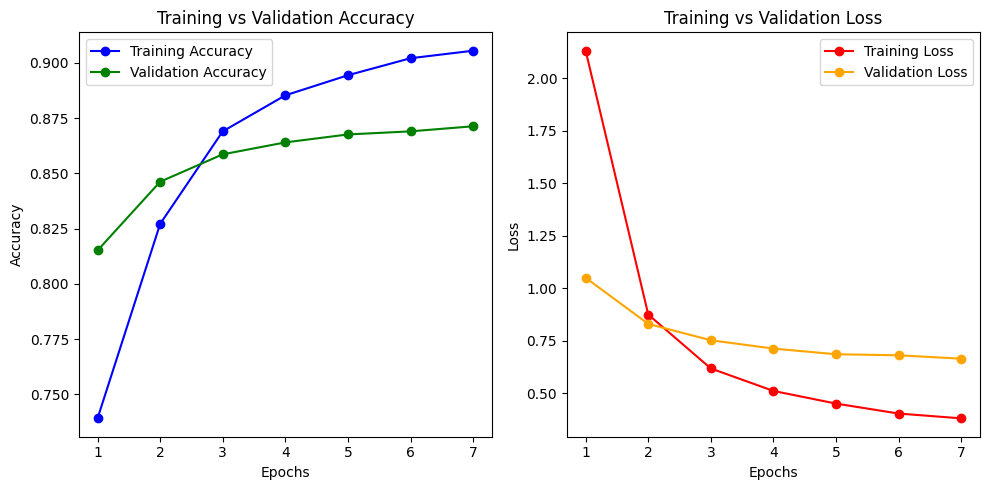

In [ ]:
import matplotlib.pyplot as plt

# accuracy and loss dari epoch 1 ke 7
epochs = [1, 2, 3, 4, 5, 6, 7]
accuracy_values = [0.7391, 0.8271, 0.8690, 0.8853, 0.8944, 0.9021, 0.9055]  #  accuracy  epoch
val_accuracy_values = [ 0.8151, 0.8462, 0.8586, 0.8640, 0.8676, 0.8690,  0.8713]
loss_values = [2.1324, 0.8747, 0.6179, 0.5108, 0.4505, 0.4030, 0.3802]  #  loss epoch
val_loss_values = [1.0500, 0.8303, 0.7523, 0.7127, 0.6857, 0.6807,  0.6646]

# Plot Accuracy
plt.figure(figsize=(10, 5))  # set size
plt.subplot(1, 2, 1)  # subplot Accuracy
plt.plot(epochs, accuracy_values, label='Training Accuracy', marker='o', color='b')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy', marker='o', color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # subplot loss
plt.plot(epochs, loss_values, label='Training Loss', marker='o', color='r')
plt.plot(epochs, val_loss_values, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
#fungsi response
def generate_response(input_text):
    # Encode input
    input_seq = tokenizer.texts_to_sequences([input_text])
    if len(input_seq[0]) == 0:  # Handle unknown input
        return "Sorry, I didn't understand that. Can you rephrase?"

    input_seq_padded = pad_sequences(input_seq, maxlen=max_len_input, padding='post')
    states_value = encoder_model.predict(input_seq_padded)

    # Decode output
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index.get('<start>', 0)

    decoded_sentence = ''
    for _ in range(max_len_output):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>' or not sampled_word:
            break
        decoded_sentence += ' ' + sampled_word

        # Update target sequence and states
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

In [ ]:
#chatbot
while True:
    user_input = input("You: ")
    if user_input.lower() in ['exit', 'quit']:
        print("Chatbot: Goodbye!")
        break
    response = generate_response(user_input)
    print("Chatbot:", response)

You: hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step